In [1]:
# ! pip install spacy==3.8.3
# ! pip install timm==1.0.12

### Import các thư viên cần thiết

In [2]:
import torch
import torch.nn as nn
# import torchtext
import os
import random
import numpy as np
import pandas as pd
import spacy
import timm
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
# from torchtext.data.utils import get_tokenizer
# from torchtext.vocab import build_vocab_from_iterator
from torchvision import transforms

### Cài đặt giá trị ngẫu nhiên cố định

In [3]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed = 59
set_seed(seed)

### Chia bộ train 
trong tập train-test-val có những câu bị thừa 2 dấu ? (nhớ xóa tay or preprocessing trước)

In [4]:
import re

# Chuỗi ban đầu
line = "COCO_val2014_000000396568.jpg#0 extra text"

# Sử dụng regex để xóa mọi thứ sau dấu # và dừng lại khi gặp khoảng trắng
line = re.sub(r'#\S*', '', line)

# Loại bỏ khoảng trắng thừa ở cuối (nếu cần)
line = line.strip()

print(line)  # Kết quả: COCO_val2014_000000396568.jpg

COCO_val2014_000000396568.jpg extra text


In [5]:
train_data = []
train_set_path = '/kaggle/input/vqa-coco-datasets/vqa_coco_dataset/vaq2.0.TrainImages.txt'

with open(train_set_path, 'r') as f:
    lines = f.readlines()
    for line in lines:
        line = re.sub(r'#\S*', '', line)
        temp = line.split('\t')
        qa = temp[1].split('?')
        

        if len(qa) == 2: 
            answer = qa[1].strip()
        elif len(qa) == 3:
            answer = qa[2].strip()
            
        data_sample = {
                'image_path': temp[0],
                'question': qa[0] + '?',
                'answer': answer
            }
        train_data.append(data_sample)


val_data = []
val_set_path = '/kaggle/input/vqa-coco-datasets/vqa_coco_dataset/vaq2.0.DevImages.txt'

with open(train_set_path, 'r') as f:
    lines = f.readlines()
    for line in lines:
        line = re.sub(r'#\S*', '', line)
        temp = line.split('\t')
        qa = temp[1].split('?')
        

        if len(qa) == 2: 
            answer = qa[1].strip()
        elif len(qa) == 3:
            answer = qa[2].strip()
            
        data_sample = {
                'image_path': temp[0],
                'question': qa[0] + '?',
                'answer': answer
            }
        val_data.append(data_sample)


test_data = []
test_set_path = '/kaggle/input/vqa-coco-datasets/vqa_coco_dataset/vaq2.0.TestImages.txt'

with open(train_set_path, 'r') as f:
    lines = f.readlines()
    for line in lines:
        line = re.sub(r'#\S*', '', line)
        temp = line.split('\t')
        qa = temp[1].split('?')
        

        if len(qa) == 2: 
            answer = qa[1].strip()
        elif len(qa) == 3:
            answer = qa[2].strip()
            
        data_sample = {
                'image_path': temp[0],
                'question': qa[0] + '?',
                'answer': answer
            }
        test_data.append(data_sample)

In [6]:
# Testing

# testing_data = []

# lines = ["COCO_val2014_000000151075.jpg#0	Is this person wearing a wetsuit ? yes",
# "COCO_val2014_000000282150.jpg#0	Could this be scooter ? no",
# "COCO_val2014_000000151084.jpg#0	Is this a beach ?? no"]

# for line in lines:
#         temp = line.split('\t')
#         qa = temp[1].split('?')
        

#         if len(qa) == 2: 
#             answer = qa[1].strip()
#         elif len(qa) == 3:
#             answer = qa[2].strip()
            
#         data_sample = {
#                 'image_path': temp[0],
#                 'question': qa[0] + '?',
#                 'answer': answer
#             }
#         testing_data.append(data_sample)
            

# print(testing_data)

### Xây vocabulary

In [7]:
from tokenizers import BertWordPieceTokenizer

# Huấn luyện tokenizer từ dữ liệu
def get_questions(train_data):
    for sample in train_data:
        yield sample['question']
# Sử dụng generator
questions = get_questions(train_data)

tokenizer = BertWordPieceTokenizer()
tokenizer.train_from_iterator(questions, vocab_size=10000, min_frequency=2, show_progress=True)
print(len(tokenizer.get_vocab()))  # Xem từ vựng được tạo


3342


In [8]:
# # Testing
# tokenizer.enable_padding(
#     length=5,  # Độ dài mong muốn
#     direction="right",  # Padding bên phải
#     pad_id=0,  # ID của padding token
#     pad_type_id=0,  # Type ID cho padding token
#     pad_token="[PAD]"  # Token padding
# )
# tokenizer.encode('What is the color of the cat?').ids

### Build dictionary mapping labels

In [9]:
classes = set(
    sample['answer'] for sample in train_data
)

labels = ['no', 'yes']

label2id = {label: i for i, label in enumerate(labels)}

id2label = {i: label for label, i in label2id.items()}

print(label2id)

{'no': 0, 'yes': 1}


### Xây dựng hàm tokenize

In [10]:
def tokenize(text, max_seq_length):
    tokenizer.enable_padding(
            length=max_seq_length,  
            direction="right", 
            pad_id=0,  
            pad_type_id=0,  
            pad_token="[PAD]" 
        )
    encode_text = tokenizer.encode(text).ids

    if len(encode_text) > max_seq_length:
        encode_text = encode_text[:max_seq_length]

    return encode_text

### Xây dựng pytorch datasets

In [11]:
class VQADatasets(Dataset):
    def __init__(self, data, label2idx, max_seq_length=20, transform=None, tokenize=None, img_dir='/kaggle/input/vqa-coco-datasets/vqa_coco_dataset/val2014-resised'):
        super().__init__()
        self.data = data
        self.label2idx = label2idx
        self.max_seq_length = max_seq_length
        self.transform = transform
        self.tokenize = tokenize
        self.img_dir = img_dir

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        try:
            img_path = os.path.join(self.img_dir, self.data[index]['image_path'])
            img = Image.open(img_path).convert('RGB')

            if self.transform:
                img = self.transform(img)

            questions = self.data[index]['question']
            questions = torch.tensor(self.tokenize(questions, self.max_seq_length))

            answer = self.data[index]['answer']
            id_label = self.label2idx[answer]
            id_label = torch.tensor(id_label)

            return img, questions, id_label
        except Exception as e:
            print(f"Error at index {index}: {e}")
            print(f"Data at index {index}: {self.data[index]}")
            raise  # Tùy chọn: bạn có thể giữ hoặc bỏ dòng này nếu muốn chương trình dừng khi gặp lỗi


### Xây dựng Transforms

In [12]:
data_transform = {
    'train': transforms.Compose([
        transforms.Resize(size=(224, 224)),
        transforms.CenterCrop(size=180),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
        transforms.RandomHorizontalFlip(),
        transforms.GaussianBlur(3),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]),
    'val': transforms.Compose([
        transforms.Resize(size=(224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])
}

### Xây dựng DataLoader

In [13]:
train_dataset = VQADatasets(
    train_data,
    label2idx=label2id,
    transform=data_transform['train'],
    tokenize=tokenize
)
val_dataset = VQADatasets(
    val_data,
    label2idx=label2id,
    transform=data_transform['val'],
    tokenize=tokenize
)
test_dataset = VQADatasets(
    test_data,
    label2idx=label2id,
    transform=data_transform['val'],
    tokenize=tokenize
)

In [14]:
train_batch_size = 256
test_batch_size = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)
val_loader = DataLoader(val_dataset, batch_size=test_batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

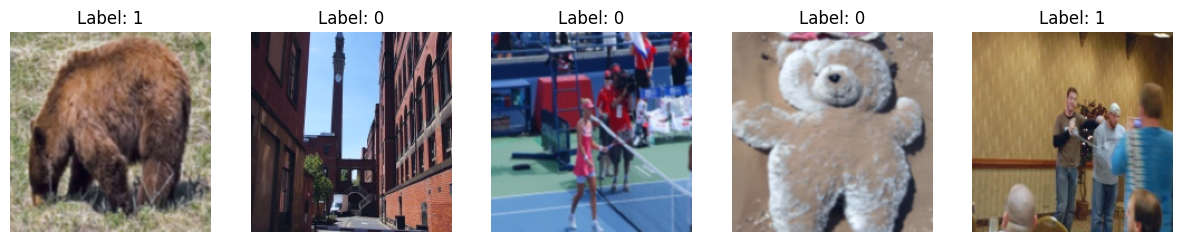

In [15]:
import matplotlib.pyplot as plt

# Lấy một batch từ train_loader
data_iter = iter(train_loader)
images, questions, labels = next(data_iter)

# Hiển thị một số ảnh trong batch
fig, axes = plt.subplots(1, 5, figsize=(15, 5))  # Hiển thị 5 ảnh
for i in range(5):
    img = images[i].permute(1, 2, 0).numpy()  # Đưa ảnh về dạng HxWxC
    img = img * 0.229 + 0.485  # Đảo ngược Normalize để hiển thị đúng màu
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f"Label: {labels[i]}")
plt.show()

### Xây dựng models

In [16]:
class VQAModel(nn.Module):
    def __init__(self,
                 n_classes,
                 vocab,
                 img_model_name,
                 embeddding_dim,
                 n_layers=2,
                 hidden_size=256,
                 drop_p=0.2):
        super().__init__()
        self.img__encoder = timm.create_model(img_model_name, pretrained=True, num_classes=hidden_size)

        for param in self.img__encoder.parameters():
            param.requires_grad = True

        self.embedding = nn.Embedding(len(vocab), embeddding_dim)
        self.lstm1 = nn.LSTM(embeddding_dim, hidden_size, n_layers, batch_first=True, bidirectional=True, dropout=drop_p)

        self.fc1 = nn.Linear(hidden_size * 3, hidden_size)
        self.dropout = nn.Dropout(drop_p)
        self.gelu = nn.GELU()
        self.fc2 = nn.Linear(hidden_size, n_classes)

    def forward(self, img, question):
        img_features = self.img__encoder(img)
        question = self.embedding(question)
        lstm_out, _ = self.lstm1(question)
        lstm_out = lstm_out[:, -1, :]
        combined = torch.cat((img_features, lstm_out), dim=1)
        
        x = self.fc1(combined)
        x = self.gelu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [17]:
n_classes = len(labels)
img_model_name = 'resnet18'
hidden_size = 256
n_layers = 2
embedding_dim = 128
drop_p = 0.2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = VQAModel(
    n_classes=n_classes,
    vocab=tokenizer.get_vocab(),
    img_model_name=img_model_name,
    embeddding_dim=embedding_dim,
    n_layers=n_layers,
    hidden_size=hidden_size,
    drop_p=drop_p
).to(device)

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

### Xây dựng hàm train và evaluate

In [18]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        for image, question, labels in dataloader:
            image, question, labels = image.to(
                device), question.to(device), labels.to(device)
            outputs = model(image, question)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = sum(losses) / len(losses)
    acc = correct / total

    return loss, acc


def fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    epochs
):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        batch_train_losses = []

        model.train()
        for idx, (images, questions, labels) in enumerate(train_loader):
            images = images.to(device)
            questions = questions.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images, questions)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss, val_acc = evaluate(
            model, val_loader,
            criterion, device
        )
        val_losses.append(val_loss)

        print(
            f'EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}\tVal Acc: {val_acc}')


        # lưu ý
        scheduler.step()

    return train_losses, val_losses

### Khai báo hàm loss, optimizer, scheduler

In [19]:
lr = 1e-3
epochs = 50

scheduler_step_size = epochs * 0.8
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=lr
)

# giảm learning ra
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=scheduler_step_size,
    gamma=0.1
)

### Trainning 

In [20]:
train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    epochs
)

EPOCH 1:	Train loss: 1.3419	Val loss: 0.6964	Val Acc: 0.4861075707366811
EPOCH 2:	Train loss: 0.7079	Val loss: 0.6943	Val Acc: 0.5173336732092786
EPOCH 3:	Train loss: 0.7036	Val loss: 0.6938	Val Acc: 0.5173336732092786
EPOCH 4:	Train loss: 0.6994	Val loss: 0.6950	Val Acc: 0.5173336732092786
EPOCH 5:	Train loss: 0.6975	Val loss: 0.6937	Val Acc: 0.49655875605404026
EPOCH 6:	Train loss: 0.6982	Val loss: 0.6906	Val Acc: 0.5173336732092786
EPOCH 7:	Train loss: 0.6939	Val loss: 0.6895	Val Acc: 0.5432067295437165
EPOCH 8:	Train loss: 0.6966	Val loss: 0.6849	Val Acc: 0.5433341830231966
EPOCH 9:	Train loss: 0.6784	Val loss: 0.6973	Val Acc: 0.549961763956156
EPOCH 10:	Train loss: 0.6719	Val loss: 0.6877	Val Acc: 0.5568442518480754
EPOCH 11:	Train loss: 0.6415	Val loss: 0.6719	Val Acc: 0.5830996686209533
EPOCH 12:	Train loss: 0.5924	Val loss: 0.6673	Val Acc: 0.5963548304868723
EPOCH 13:	Train loss: 0.5275	Val loss: 0.6472	Val Acc: 0.6343359673719092
EPOCH 14:	Train loss: 0.4483	Val loss: 0.6172	V

In [21]:
val_loss, val_acc = evaluate(
    model,
    val_loader,
    criterion,
    device
)

test_loss, test_acc = evaluate(
    model,
    test_loader,
    criterion,
    device
)

print('Evaluation on val / test dataset')
print('Val accuracy:', val_acc)
print('Test accuracy:', test_acc)

Evaluation on val / test dataset
Val accuracy: 0.761661993372419
Test accuracy: 0.761661993372419
